In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Notebook 4: Collection Movie Analysis

In this Notebook, we specifically look at collection movies

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# plt.style.use('seaborn')

## 1. Read, concat, and save data

In [3]:
df = pd.read_csv('Collection_data/imdb movies.csv')
df_coll=df[~pd.isna(df['belongs to collection'])]
dv = pd.read_csv('Collection_data/missing_collections.csv')
def clean(i):
    c = dv['0']
    c = tuple(set(c.unique()))
    if i in c:
        return False
    else:
        return True

df_coll['a']=df_coll['belongs to collection'].apply(clean)
df_coll=df_coll[df_coll['a']==True]
del df_coll['Unnamed: 0']
df_coll.reset_index(inplace = True)
del df_coll['index']
del df_coll['a']
df_coll.to_csv(r'Collection_data/raw collection movie.csv')

/Users/Jim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [4]:
df = pd.read_csv('Collection_data/raw collection movie.csv')
cf = pd.read_csv('Collection_data/14 Econ Index.csv')[['DATE','Producer_Price_Index']]
del df['Unnamed: 0']

/Users/Jim/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (26,33,34,35,36,53,70,71,72,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,93,95,96,97,100,106,107,111,112,113,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,184,185,186,187,188,189,190,196,197,202,203,204,205,206,207,209,211,212,213,214,215,216,217,219,220,222,224,227,229,230,233,238,239,241,242,243,244,245,246,247,248,250,251,252,253,255,256,257,258,259,260,262,263,264,265,266,269,270,272,273,282,283,285,289,290,300,301,302,303,304,305,306,308,309,310,311,313,314,315,316,317,318,319,323,327,333,334,335,341,342,343,344,346,349,351,352,353,354,355,356,357,370,371,382,387,394,395,409,415,420,425,426,430,441,442,443,444,463,466,467,468,481,487,490,503,504,505,507

## 2. Insert ppi values

In [5]:
df['month_year'] = pd.to_datetime(df['release date']).dt.to_period('M')
cf['month_year']=pd.to_datetime(cf['DATE']).dt.to_period('M')
ppi_year = {cf['month_year'][i]:cf['Producer_Price_Index'][i] for i in range(len(cf))}
df['ppi']=pd.Series([None]*len(df))
for j in range(len(df)):
    if df['month_year'][j] in list(ppi_year.keys()):
        df['ppi'][j] = ppi_year[df['month_year'][j]]
    else:
        continue

/Users/Jim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## 3. Data cleaning
 ### 3.1 Drop a whole series/collection if null value exists in any movie belonging to the series/collection

In [6]:
df = df[['imdb id','genre','release date','month_year','rate','budget','gross usa','cumulative worldwide gross','belongs to collection','ppi']]
grouped = df.groupby('belongs to collection')
for name,data in grouped:
    check = data[['genre','release date','month_year','rate','budget','gross usa','cumulative worldwide gross','ppi']]
    if check.isnull().any().any():
        df = df.drop(grouped.get_group(name).index)
    elif len(check) == 1:
        df = df.drop(grouped.get_group(name).index)
df = df.reset_index(inplace=False)
del df['index']

In [7]:
min_ppi = df[df['release date'] == min(df['release date'])]['ppi']
for i in range(len(df)):
    df['budget'][i] = (df['budget'][i]/df['ppi'][i])*min_ppi
    df['gross usa'][i] = (df['gross usa'][i]/df['ppi'][i])*min_ppi
    df['cumulative worldwide gross'][i] = (df['cumulative worldwide gross'][i]/df['ppi'][i])*min_ppi

/Users/Jim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Jim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Jim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### 3.2 Drop abnormal return rate

In [8]:
df['return rate worldwide'] = df['cumulative worldwide gross']/df['budget']
df['return rate usa'] = df['gross usa']/df['budget']
grouped = df.groupby('belongs to collection')
for name,data in grouped:
    check_w = data[['return rate worldwide']]
    check_u = data[['return rate usa']]
    minimum_w = float(check_w.min())
    maximum_w = float(check_w.max())
    minimum_u = float(check_u.min())
    maximum_u = float(check_u.max())
    if minimum_w<0.1 or maximum_w>100 or minimum_u<0.1 or maximum_u>100:
        df = df.drop(grouped.get_group(name).index)

df = df.reset_index(inplace=False)
del df['index']

### 3.3 Check sample size of series/collections with specific length (number of movie) and drop series/collections with small sample size (7,12,8,25,6)

In [9]:
df = df.sort_values(by=['belongs to collection','release date'])
df = df.reset_index(inplace=False)
del df['index']

In [10]:
groups = df.groupby('belongs to collection')
movie_num = dict()
for collection,info in groups:
    if len(info) not in movie_num.keys():
        movie_num[len(info)] = 1
    else:
        movie_num[len(info)] = movie_num[len(info)]+1
movie_num

{3: 56, 2: 183, 7: 2, 4: 20, 5: 14, 12: 1, 8: 3, 25: 1, 6: 2}

In [11]:
groups = df.groupby('belongs to collection')
num = [2,3,4,5,6,7,8,12,25]
collection_num = []
movie_num =[]
for collection,info in groups:
    for index in num:
        if len(info)==index:
            collection_num.extend([index]*index)
            movie_num.extend(range(1,index+1))
df['collection_num'] = pd.Series(collection_num)
df['movie_num'] = pd.Series(movie_num)

In [12]:
grouped = df.groupby('belongs to collection')
for name,data in grouped:
    check = data[['collection_num']]
    if len(check) in [7,12,8,25,6]:
        df = df.drop(grouped.get_group(name).index)
df = df.reset_index(inplace=False)
del df['index']

## 4. Analysis

### 4.1 Calculate return rate for all collections and plot it
### Finding: Average return rate is negatively related to the order in the movie length, new released movies in a collection tend to have a lower return rate than the previous one

In [13]:
# calculate return rate(both usa and worldwide)
groups = df.groupby('movie_num')
average_return_rate_w = dict()
average_return_rate_u = dict()
for num, info in groups:
    info_w = info['return rate worldwide']
    info_u = info['return rate usa']
    average_return_rate_w[num]=info_w.mean()
    average_return_rate_u[num]=info_u.mean()

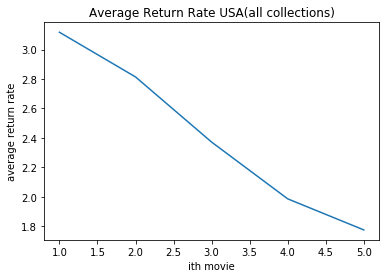

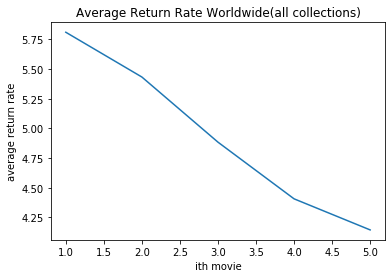

In [14]:
# plot usa return rate
smoothed_u = gaussian_filter1d(list(average_return_rate_u.values()),sigma=2)
line_chart_w = plt.plot(range(1,6), smoothed_u)

plt.title('Average Return Rate USA(all collections)')
plt.xlabel('ith movie')
plt.ylabel('average return rate')

plt.show()

# plot worldwide return rate
smoothed_w = gaussian_filter1d(list(average_return_rate_w.values()),sigma=2)
line_chart_w = plt.plot(range(1,6), smoothed_w)

plt.title('Average Return Rate Worldwide(all collections)')
plt.xlabel('ith movie')
plt.ylabel('average return rate')

plt.show()

### 4.2 Calculate return rate by series/collections and plot it
 - return Rate on ith movie, group by collection length

In [15]:
groups = df.groupby(['collection_num','movie_num'])
average_return_rate_ith_movie_u = dict()
average_return_rate_ith_movie_w = dict()
for num,info in groups:
    info_u = info['return rate usa']
    info_w = info['return rate worldwide']
    average_return_rate_ith_movie_u[num]=info_u.mean()
    average_return_rate_ith_movie_w[num]=info_w.mean()

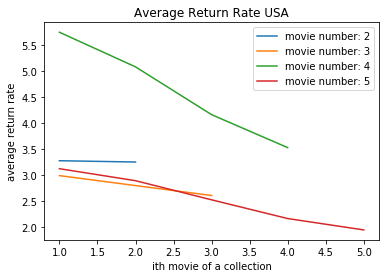

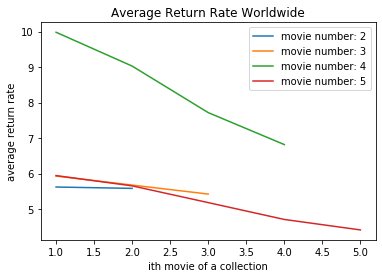

In [16]:
# plot usa return rate
smoothed_u2 = gaussian_filter1d(list(average_return_rate_ith_movie_u.values())[:2],sigma=2)
smoothed_u3 = gaussian_filter1d(list(average_return_rate_ith_movie_u.values())[2:5],sigma=2)
smoothed_u4 = gaussian_filter1d(list(average_return_rate_ith_movie_u.values())[5:9],sigma=2)
smoothed_u5 = gaussian_filter1d(list(average_return_rate_ith_movie_u.values())[9:14],sigma=2)
line_chart_u2 = plt.plot(range(1,3), smoothed_u2)
line_chart_u3 = plt.plot(range(1,4), smoothed_u3)
line_chart_u4 = plt.plot(range(1,5), smoothed_u4)
line_chart_u5 = plt.plot(range(1,6), smoothed_u5)

plt.title('Average Return Rate USA')
plt.xlabel('ith movie of a collection')
plt.ylabel('average return rate')
plt.legend(['movie number: 2','movie number: 3','movie number: 4','movie number: 5'])
plt.show()

# plot worldwide return rate
smoothed_w2 = gaussian_filter1d(list(average_return_rate_ith_movie_w.values())[:2],sigma=2)
smoothed_w3 = gaussian_filter1d(list(average_return_rate_ith_movie_w.values())[2:5],sigma=2)
smoothed_w4 = gaussian_filter1d(list(average_return_rate_ith_movie_w.values())[5:9],sigma=2)
smoothed_w5 = gaussian_filter1d(list(average_return_rate_ith_movie_w.values())[9:14],sigma=2)
line_chart_w2 = plt.plot(range(1,3), smoothed_w2)
line_chart_w3 = plt.plot(range(1,4), smoothed_w3)
line_chart_w4 = plt.plot(range(1,5), smoothed_w4)
line_chart_w5 = plt.plot(range(1,6), smoothed_w5)

plt.title('Average Return Rate Worldwide')
plt.xlabel('ith movie of a collection')
plt.ylabel('average return rate')
plt.legend(['movie number: 2','movie number: 3','movie number: 4','movie number: 5'])
plt.show()

### 4.3 Calculate gross and plot it

In [17]:
groups = df.groupby(['collection_num','movie_num'])
average_usa_gross_ith_movie = dict()
for num,info in groups:
    info = info['gross usa']
    average_usa_gross_ith_movie[num]=info.mean()

grouped = df.groupby(['collection_num','movie_num'])
average_world_gross_ith_movie = dict()
for num,info in grouped:
    info = info['cumulative worldwide gross']
    average_world_gross_ith_movie[num]=info.mean()

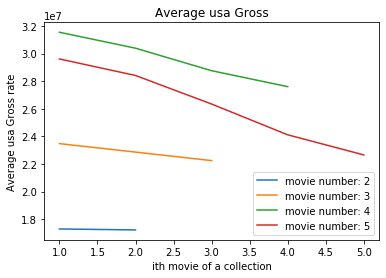

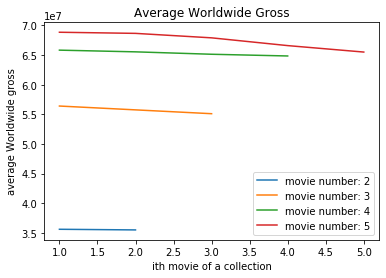

In [18]:
# usa gross
smoothed_u2 = gaussian_filter1d(list(average_usa_gross_ith_movie.values())[:2],sigma=2)
smoothed_u3 = gaussian_filter1d(list(average_usa_gross_ith_movie.values())[2:5],sigma=2)
smoothed_u4 = gaussian_filter1d(list(average_usa_gross_ith_movie.values())[5:9],sigma=2)
smoothed_u5 = gaussian_filter1d(list(average_usa_gross_ith_movie.values())[9:14],sigma=2)
plt.plot(range(1,3), smoothed_u2)
plt.plot(range(1,4), smoothed_u3)
plt.plot(range(1,5), smoothed_u4)
plt.plot(range(1,6), smoothed_u5)

plt.title('Average usa Gross')
plt.xlabel('ith movie of a collection')
plt.ylabel('Average usa Gross rate')
plt.legend(['movie number: 2','movie number: 3','movie number: 4','movie number: 5'])
plt.show()


# worldwide gross
smoothed_w2 = gaussian_filter1d(list(average_world_gross_ith_movie.values())[:2],sigma=2)
smoothed_w3 = gaussian_filter1d(list(average_world_gross_ith_movie.values())[2:5],sigma=2)
smoothed_w4 = gaussian_filter1d(list(average_world_gross_ith_movie.values())[5:9],sigma=2)
smoothed_w5 = gaussian_filter1d(list(average_world_gross_ith_movie.values())[9:14],sigma=2)
line_chart_w2 = plt.plot(range(1,3), smoothed_w2)
line_chart_w3 = plt.plot(range(1,4), smoothed_w3)
line_chart_w4 = plt.plot(range(1,5), smoothed_w4)
line_chart_w5 = plt.plot(range(1,6), smoothed_w5)

plt.title('Average Worldwide Gross')
plt.xlabel('ith movie of a collection')
plt.ylabel('average Worldwide gross')
plt.legend(['movie number: 2','movie number: 3','movie number: 4','movie number: 5'])
plt.show()
# plt.savefig('Average Worldwide Gross.png')

### 4.4 Calculate budget and plot it

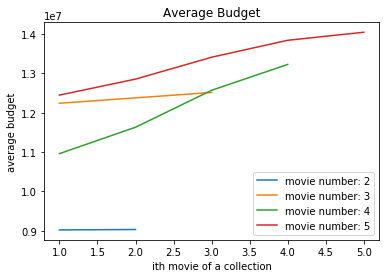

In [19]:
groups = df.groupby(['collection_num','movie_num'])
average_budget_ith_movie = dict()
for num,info in groups:
    info = info['budget']
    average_budget_ith_movie[num]=info.mean()

smoothed2 = gaussian_filter1d(list(average_budget_ith_movie.values())[:2],sigma=2)
smoothed3 = gaussian_filter1d(list(average_budget_ith_movie.values())[2:5],sigma=2)
smoothed4 = gaussian_filter1d(list(average_budget_ith_movie.values())[5:9],sigma=2)
smoothed5 = gaussian_filter1d(list(average_budget_ith_movie.values())[9:14],sigma=2)


line_chart2 = plt.plot(range(1,3), smoothed2)
line_chart3 = plt.plot(range(1,4), smoothed3)
line_chart4 = plt.plot(range(1,5), smoothed4)
line_chart5 = plt.plot(range(1,6), smoothed5)

plt.title('Average Budget')
plt.xlabel('ith movie of a collection')
plt.ylabel('average budget')
plt.legend(['movie number: 2','movie number: 3','movie number: 4','movie number: 5'])

plt.show()